In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from datetime import datetime, timedelta
from utils import find_date_range

In [3]:
df_pre = pd.read_csv('Pre-FTB_Report.csv')
df_post = pd.read_csv('Post-FTB_Report.csv')

In [4]:
df_pre['Annual hotel spend'] = df_pre['Annual hotel spend'].fillna(0).astype(int)
df_post['Annual hotel spend'] = df_post['Annual hotel spend'].fillna(0).astype(int)

In [5]:
ownerID = 1
owner = list(df_pre['Opportunity Owner'])[ownerID]
print(owner)

Zac Oliver


In [6]:
df0 = df_pre[df_pre['Opportunity Owner']==owner]
df1 = df0.dropna(subset=['Expected FTB Date'])
df2 = df1[['Account Name','Expected FTB Date','Annual hotel spend']]
#df2

In [7]:
# Define the range using the first and second dates
start_date_str = find_date_range(df2['Expected FTB Date'])[0]
end_date_str = find_date_range(df2['Expected FTB Date'])[1]

# Convert the start and end dates to datetime objects
start_date = datetime.strptime(start_date_str, "%m/%d/%Y")
end_date = datetime.strptime(end_date_str, "%m/%d/%Y")

# Add one year to the end date
end_date_plus_one_year = end_date + timedelta(days=365)

# Iterate through the months and print the abbreviated month and year

col = [0 for i in range(len(df2))]

current_date = start_date
while current_date < end_date_plus_one_year:
    #print(current_date.strftime("%b %Y"))
    df2[str(current_date.strftime("%b %Y"))] = col
    current_date += timedelta(days=30)

<ipython-input-7-d5a987eeabe9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[str(current_date.strftime("%b %Y"))] = col


In [8]:
for i in range(len(df2)): # loop over accounts for given owner
    start_date = df2.at[df2.index[i],'Expected FTB Date']
    spend = df2.at[df2.index[i],'Annual hotel spend']
    # Convert the date string to a datetime object
    date = datetime.strptime(start_date, "%m/%d/%Y")
    # loop over the following 12 months
    for j in range(12):
        label = date.strftime("%b %Y")  # Format the date as "Abbreviated Month Year"
        df2.at[df2.index[i],label] = round(spend/12)
        # Add 30 days to the date for the next month
        date += timedelta(days=30)
    # to make sure empty months don't return NaN when divided by zero:
    df2.fillna(int(0), inplace=True, downcast='infer') 

In [9]:
# This reproduces the content of "Prospect (Pre-FTB) detail"
# Now I need to reproduce "Customers (Post-FTB) Detail"
# and "Pipeline Summary"

sorted_df2 = df2.sort_values(by='Account Name')
sorted_df2

,Account Name,Expected FTB Date,Annual hotel spend,Nov 2022,Dec 2022,Jan 2023,Feb 2023,Mar 2023,Apr 2023,May 2023,...,Sep 2023,Oct 2023,Nov 2023,Dec 2023,Jan 2024,Feb 2024,Mar 2024,Apr 2024,May 2024,Jun 2024
15,AGI,4/13/2023,200001,0,0,0,0,0,16667,16667,...,16667,16667,16667,16667,16667,16667,16667,0,0,0
494,Affinitiv,2/9/2023,200001,0,0,0,16667,16667,16667,16667,...,16667,16667,16667,16667,16667,0,0,0,0,0
575,Agent Legal,12/8/2022,200001,0,16667,16667,16667,16667,16667,16667,...,16667,16667,16667,0,0,0,0,0,0,0
295,Aktiv Construction,11/30/2022,85000,7083,7083,7083,7083,7083,7083,7083,...,7083,7083,0,0,0,0,0,0,0,0
828,BKW,1/12/2023,200001,0,0,16667,16667,16667,16667,16667,...,16667,16667,16667,16667,0,0,0,0,0,0
336,BP Fabrication,12/15/2022,200000,0,16667,16667,16667,16667,16667,16667,...,16667,16667,16667,0,0,0,0,0,0,0
1004,Blue Bird Corporation,2/21/2023,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194,Branded Image Group LLC,1/12/2023,100001,0,0,8333,8333,8333,8333,8333,...,8333,8333,8333,8333,0,0,0,0,0,0
725,Bristol Management Services,1/31/2023,100000,0,0,8333,0,8333,8333,8333,...,8333,8333,8333,8333,0,0,0,0,0,0
929,"Conexon, LLC",2/23/2023,250001,0,0,0,20833,20833,20833,20833,...,20833,20833,20833,20833,20833,0,0,0,0,0


In [10]:
numeric_columns = sorted_df2.select_dtypes(include='number')
cols = numeric_columns.columns

In [11]:
# Here are the first two lines of "Pipeline Summary":

numeric_columns = sorted_df2.select_dtypes(include='number')
df1exp = (pd.DataFrame(numeric_columns.sum()))
df2exp = pd.DataFrame((sorted_df2[cols] != 0).sum())

df1exp.rename(columns={0: '$ Expected FTB Booking'}, inplace=True)
df2exp.rename(columns={0: '# Expected FTB Accounts'}, inplace=True)

df_exp = (pd.concat([df1exp, df2exp], axis=1)[1:]).transpose()

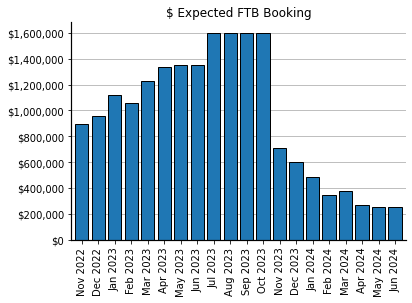

In [12]:
import matplotlib.ticker as mticker

ax = (df_exp.T).plot(kind='bar',
                y='$ Expected FTB Booking',
                rot=90, width=0.8, edgecolor='black',
                legend=False,
                title='$ Expected FTB Booking');
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.spines['left'].set_linewidth(1.2)   # Left spine
ax.spines['bottom'].set_linewidth(1.2) # Bottom spine
ax.spines['right'].set_visible(False) # Right spine
ax.spines['top'].set_visible(False)   # Top spine

# Format y-axis tick labels
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
#plt.legend()
#plt.show